### Задание 5.2.

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

1) Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2) Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3) Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
import numpy as np
import seaborn as sns
import scipy
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import pandahouse

In [2]:
# Загружаем данные о количестве просмотров и лайков полизователей из 2 и 1 экспериментальной группы за период с 30 июня по 6 июля, считаем их CTR
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'******',
                      'user':'student', 
                      'password':'******'
                     }


query = """
    SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (2,1)
    GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(query, connection=connection)

# взглянем на количество пользователей в каждой группе
df.groupby('exp_group').user_id.count()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

### Визуализируем распределения CTR в обеих группах

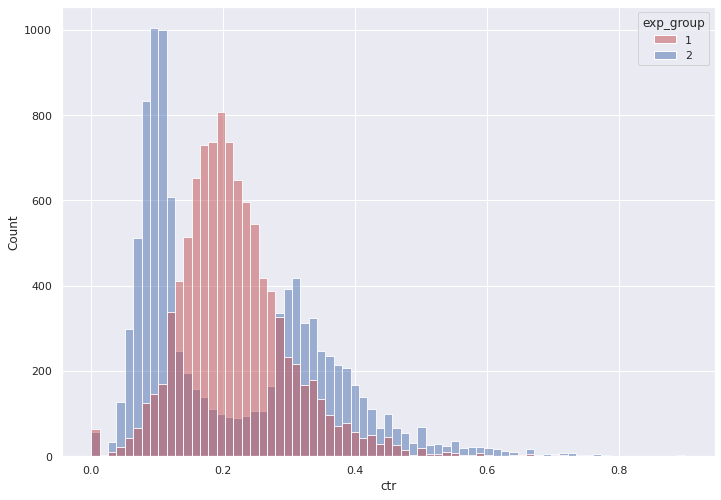

In [3]:
# Нарисуем распределение CTR в группах

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределение CTR в тестовой группе оказалось бимодальным. 

Дополнительно взглянем на описательные статистики CTR в обеих группах.

In [4]:
df.groupby('exp_group').ctr.describe()

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
1,10020.0,0.216774,0.082969,0.0,0.163636,0.205882,0.257870,0.722222
2,9877.0,0.216102,0.142870,0.0,0.096774,0.153285,0.323529,0.900000


Перед тем, как переходить к сравнению групп с помощью статистических тестов, обозначим, что в качестве уровня значимости примем **5%**.

*****
### Сравнение поюзерных CTR с помощью T-Test

In [5]:
# применим ttest
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

В случае T-testа нулевая гипотеза заключается в том, что средние значения CTR в обеих группах равны. Применив его к нашим выборкам, мы получили p-value, равное 0.685, и довольно низкое значение t-статистики. Значит, оснований для отклонения нулевой гипотезы у нас нет.

Средние значения наших выборок оказались действительно практически равны - около 0.216. Но при этом внешний вид распределений CTR свидетельствует, что введение нового алгоритма рекомендаций в тестовой группе всё-таки каким-то образом повлияло на CTR.
***** 

### Сравнение сглаженных CTR с помощью T-Test

In [6]:
# Посчитаем глобальный CTR 1 и 2 экспериментальных групп
group_1 = df[df.exp_group == 1]
group_2 = df[df.exp_group == 2]
global_ctr_1 = group_1.likes.sum()/group_1.views.sum()
global_ctr_2 = group_2.likes.sum()/group_2.views.sum()
print(global_ctr_1, global_ctr_2)

0.2096041628394293 0.20025051027061783


In [7]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

/tmp/ipykernel_362/273129146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1['smoothed_ctr'] = df.apply(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

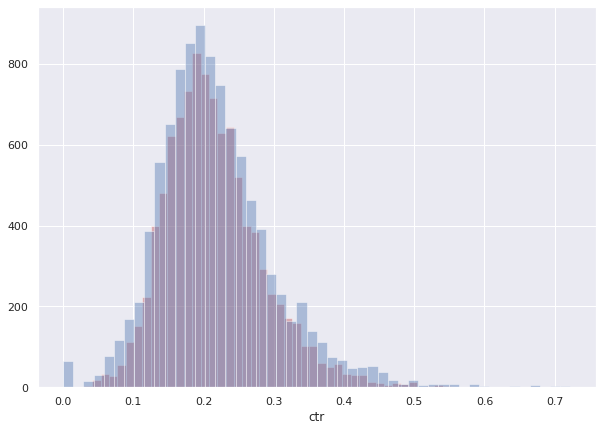

In [8]:
# Посчитаем сглаженный CTR для пользователей из 1 группы
group_1['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

# Визуализируем распределение сглаженных CTR и фактических CTR 1 группы
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(group_1.smoothed_ctr,
             kde = False,
             color = 'r')
sns.distplot(group_1.ctr,
             kde = False,
             color = 'b')

/tmp/ipykernel_362/1207997953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2['smoothed_ctr'] = df.apply(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

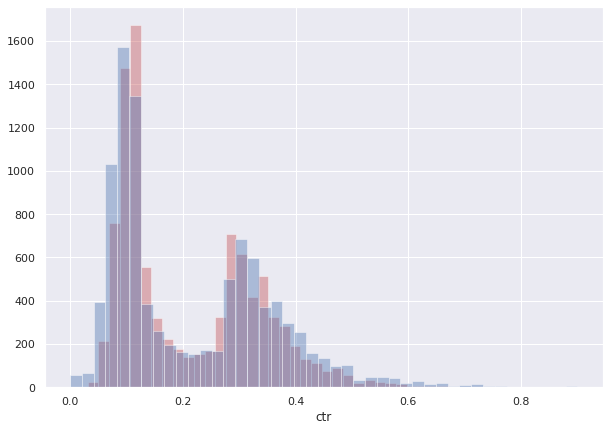

In [9]:
# Посчитаем сглаженный CTR для пользователей из 2 группы
group_2['smoothed_ctr'] = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

# Визуализируем распределение сглаженных CTR и фактических CTR 2 группы
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(group_2.smoothed_ctr,
             kde = False,
             color = 'r')
sns.distplot(group_2.ctr,
             kde = False,
             color = 'b')

По графикам нельзя сказать, что сглаживание существенно изменило распределения CTR-ов обеих групп. Однако видно, что хвосты распределений стали меньше.

Применим T-test.

In [10]:
stats.ttest_ind(group_1.smoothed_ctr, group_2.smoothed_ctr, equal_var=False)

Ttest_indResult(statistic=1.9460491517027678, pvalue=0.05166679015318533)

Значение t-статистики при сравнении сглаженных CTR в группах оказался уже значительно выше, чем в случае с CTR, над которым не производились манипуляции. 

Вероятно это связано с тем, что во второй группе общегрупповой CTR меньше почти на 1 процентный пункт, а также тем, что в ней было больше пользователей с высоким CTR, которые совершили совсем немного действий. В результате сглаживания CTR этих пользователей стали близки к общегрупповому, а среднее значение этой метрики во второй группе уменьшилось в большей степени, чем в первой. 

Посчитаем средние значения CTR и сглаженных CTR в обеих группах:

In [11]:
print('Группа 1:')
print(group_1[['ctr', 'smoothed_ctr']].mean())
print()
print('Группа 2:')
print(group_2[['ctr', 'smoothed_ctr']].mean())

Группа 1:
ctr             0.216774
smoothed_ctr    0.215280
dtype: float64

Группа 2:
ctr             0.216102
smoothed_ctr    0.212508
dtype: float64


Действительно, во второй группе среднее сглаженных CTR отличается от среднего фактических CTR примерно на 0.36 процентных пункта, а в первой - примерно на 0,15 п.п. То есть в числителе формулы для расчета t-статистики в результате произведенного преобразования теперь большее число.

Не смотря на всё перечисленное, p-value, полученный в результате применения t-теста на сглаженных CTR равен 0.0517, что не дает нам оснований для отклонения нулевой гипотезы о равенстве средних в 1 и 2 группах.
*****

### Сравнение поюзерных CTR с помощью теста Манна-Уитни

In [12]:
# применим тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr)
                

MannwhitneyuResult(statistic=43777627.0, pvalue=4.632205841806026e-45)

При применении теста Манна-Уитни p-value получился намного меньше, чем 0.05, то есть значимые различия между группами 1 и 2 есть. 

Если точнее, результат теста позволяет нам принять такую альтернативную гипотезу: вероятность того, что CTR случайного пользователя из одной группы будет больше, чем у случайного пользователя из другой, отличается от вероятности противоположного исхода. 

Возникает вопрос, для какой из групп эта гипотеза верна?
Как вариант, можем посмотреть на боксплоты CTR-ов.

<AxesSubplot:xlabel='ctr', ylabel='str_exp_group'>

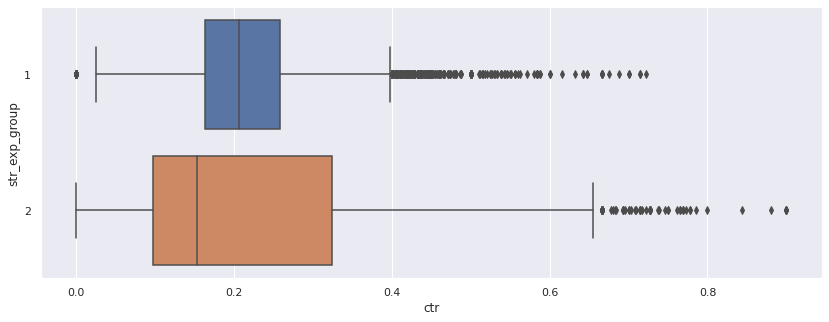

In [13]:
df['str_exp_group'] = [str(i) for i in df.exp_group]
sns.set(rc={'figure.figsize':(14,5)})
sns.boxplot(data = df,
              x='ctr',
              y='str_exp_group')
              #palette = ['r', 'b'])

На графике видно, что более 75% пользователей из группы 1 имеют большее значение CTR, чем 50% пользователей в группе 2. Принимая это во внимание и имея представление о том, как работает тест Манна-Уитни, можно сделать вывод, что полученные значения статистики и p-value свидетельствуют, что раскатывание нового алгоритма рекомендации постов на всех пользователей приведет к снижению CTR у большинства из них. 


### Пуассоновский бутстреп для подсчета разницы в CTR

In [14]:
# возьмем функцию из лекции

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

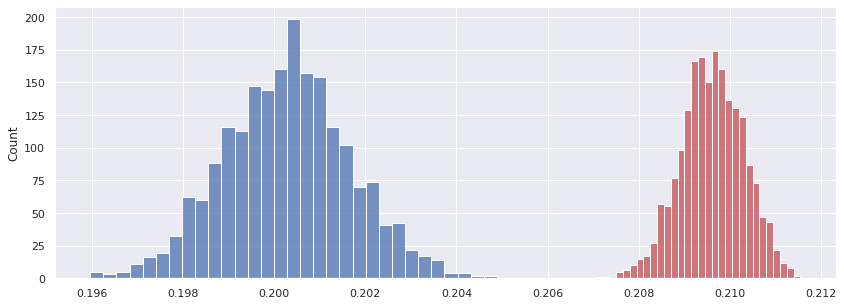

In [15]:
# Посчитаем по 2000 глобальных CTR для псевдовыборок из групп 1 и 2
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

# Визуализируем распределения получившихся глобальных CTR
sns.histplot(ctr1, color = 'r')
sns.histplot(ctr2, color = 'b')

<AxesSubplot:ylabel='Count'>

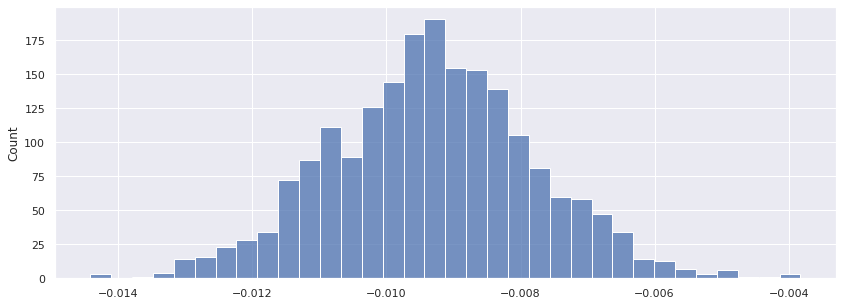

In [16]:
#Визуализируем распределение разниц между глобальными CTR
sns.histplot(ctr2 - ctr1)

Распределения глобальных СTR, сформированные методом пуассоновского бутстрепа имеют форму, очень схожую с нормальным распределением, значит, мы вполне могли бы сравнить их с помощью t-теста. 

Правда в нашем случае в этом нет необходимости, так как они не пересекаются, а распределение разниц между глобальными CTR псевдовыборок из группы 2 и из группы 1 целиком лежит ниже нуля. Таким образом, бутстреп показывает, что в тестовой группе глобальный CTR меньше, чем в контрольной.


****

### Бакетное преобразование

In [17]:
# функция для солёного хэширования
import hashlib
def ab_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [18]:
# сформируем 50 бакетов
df['hash_group'] = df.user_id.apply(ab_split)
# Смотрим на число пользователей в группах
df.groupby(['hash_group', 'exp_group']).user_id.nunique().reset_index()

,hash_group,exp_group,user_id
0,0,1,199
1,0,2,191
2,1,1,197
3,1,2,192
4,2,1,219
...,...,...,...
95,47,2,176
96,48,1,214
97,48,2,202
98,49,1,205


In [19]:
# Считаем CTR для "метапользователей"
buckets = df.groupby(['hash_group', 'exp_group'], as_index = False).agg({'likes':'sum', 'views':'sum'})
buckets['ctr'] = buckets.likes / buckets.views
buckets.head()

,hash_group,exp_group,likes,views,ctr
0,0,1,2937,13646,0.215228
1,0,2,2368,11790,0.200848
2,1,1,2747,12835,0.214024
3,1,2,2180,12048,0.180943
4,2,1,3173,15106,0.210049


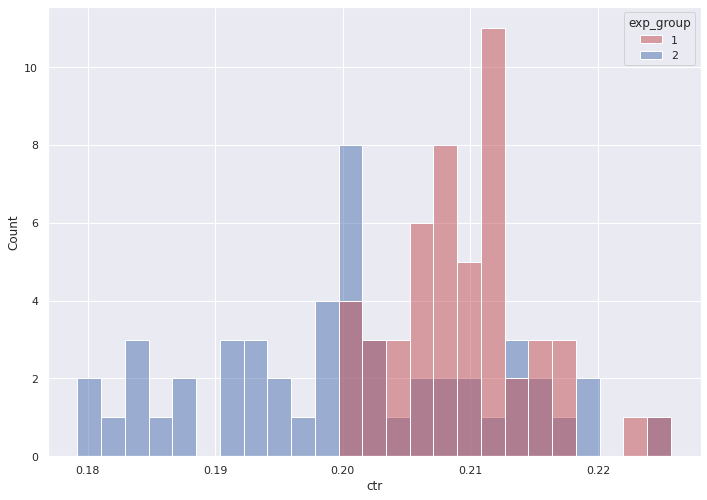

In [20]:
# Нарисуем распределение CTR в группах

sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = buckets,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False,
              bins = 25)

Распределения бакетных CTR отдаленно напоминают нормальное (особенно у группы 1). 

Сравним получившиеся группы с помощью t-теста и теста Манна-Уитни.

In [21]:
# применим ttest
scipy.stats.ttest_ind(buckets[buckets.exp_group == 1].ctr,
                buckets[buckets.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=5.3626239076242905, pvalue=9.515544473482383e-07)

In [22]:
# применим тест Манна-Уитни
scipy.stats.mannwhitneyu(buckets[buckets.exp_group == 1].ctr,
                buckets[buckets.exp_group == 2].ctr)

MannwhitneyuResult(statistic=1923.0, pvalue=3.5505478185193758e-06)

Оба теста демонстрируют значимые различия между бакетными CTR контрольной и тестовой групп. Гистограмма распределения этой метрики в группах подсказывает, что значимо меньше они в группе № 2 (тестовой).
****

### Вывод по итогам применения статистических тестов

Для сравнения CTR пользователей из группы, в которой был использован новый алгоритм рекомендации постов, с контрольной  были использованы следующие методы:

* t-тест;
* t-тест на сглаженных CTR;
* тест Манна-Уитни;
* Пуассоновский бутстреп;
* t-тест поверх бакетного преобразования;
* тест Манна-Уитни поверх бакетного преобразования.

Первые два метода не дали оснований для отклонения нулевой гипотезы о равенстве средних CTR в группах. Результаты остальных свидетельствуют о том, что CTR в группе 2 (тестовой) меньше, чем в группе 1 (контрольной). То, что распределение CTR во второй группе очевидно ненормально, дает нам основания относиться к результатам t-теста со скепсисом.

Таким образом, мы не можем рекомендовать раскатывать новый алгоритм на всех пользователей, так как она не приводит к увеличению CTR. Более вероятно, его использование приведет к снижению значения этой метрики.
При этом алгоритм рекомендации постов, использовавшийся в группе 2, как-будто разделил пользователей на две категории, создав на графике распределения CTR два "горба". У большинства пользователей CTR снизился, но одновременно с этим выделилась большая группа пользователей, у которых CTR оказался выше, чем средний в контрольной группе. В связи с этим можно предположить, что этот алгоритм может быть полезен.